In [1]:
from pynq import Overlay
from pynq import allocate
import numpy as np
# overlay = Overlay('fir_float.bit')
overlay = Overlay('fir_fixed.bit')

In [2]:
ip = overlay.fir_fixed_0
# ip = overlay.fir_0
mmio = ip.mmio
register_map = ip.register_map
registers = register_map._register_classes

In [3]:
for name, reg in registers.items():
    print(name, reg)

CTRL (<class 'pynq.registers.RegisterCTRL'>, 0, 32, None, None, 'read-write')
GIER (<class 'pynq.registers.RegisterGIER'>, 4, 32, None, None, 'read-write')
IP_IER (<class 'pynq.registers.RegisterIP_IER'>, 8, 32, None, None, 'read-write')
IP_ISR (<class 'pynq.registers.RegisterIP_ISR'>, 12, 32, None, None, 'read-write')
input_r_1 (<class 'pynq.registers.Registerinput_r_1'>, 16, 32, None, None, 'write-only')
input_r_2 (<class 'pynq.registers.Registerinput_r_2'>, 20, 32, None, None, 'write-only')
output_r_1 (<class 'pynq.registers.Registeroutput_r_1'>, 28, 32, None, None, 'write-only')
output_r_2 (<class 'pynq.registers.Registeroutput_r_2'>, 32, 32, None, None, 'write-only')


In [4]:
# Allocated buffer (m_axi)
input_buffer_size = 1024
output_buffer_size = 1024

input_buffer = allocate(shape=(input_buffer_size,), dtype=np.float32) 
output_buffer = allocate(shape=(output_buffer_size,), dtype=np.float32) 
register_map.input_r_1.input_r = input_buffer.device_address
register_map.output_r_1.output_r = output_buffer.device_address


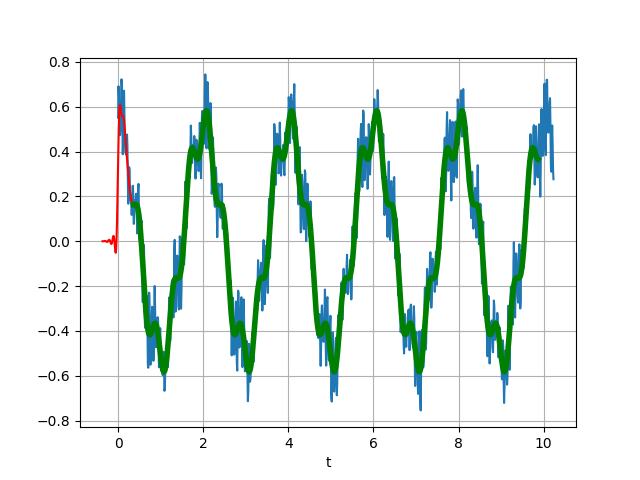

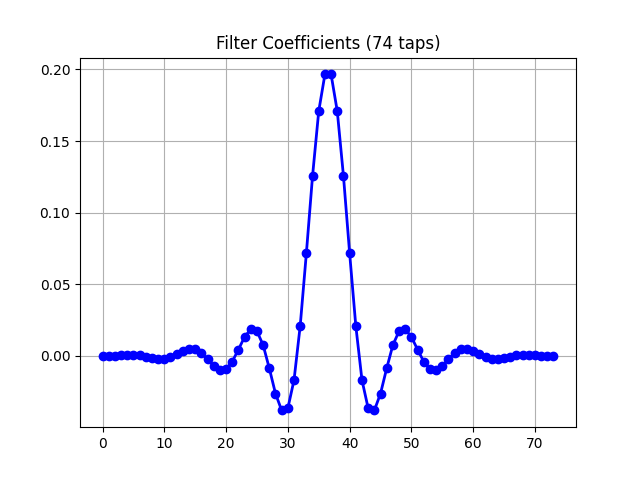

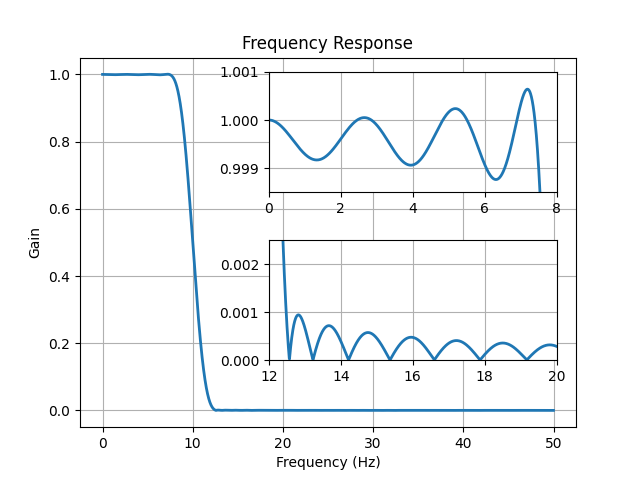

In [5]:
from numpy import cos, sin, pi, absolute, arange
from scipy.signal import kaiserord, lfilter, firwin, freqz
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show
#------------------------------------------------
# Create a signal for demonstration.
#------------------------------------------------

sample_rate = 100.0
nsamples = 1024
t = arange(nsamples) / sample_rate
x = ((cos(2*pi*0.5*t) + 0.2*sin(2*pi*2.5*t+0.1) + \
        0.2*sin(2*pi*15.3*t) + 0.1*sin(2*pi*16.7*t + 0.1) + \
            0.1*sin(2*pi*23.45*t+.8)).astype(np.float32))/2


#------------------------------------------------
# Create a FIR filter and apply it to x.
#------------------------------------------------

# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 5.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
cutoff_hz = 10.0

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = (firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))).astype(np.float32)

# Use lfilter to filter x with the FIR filter.
filtered_x = lfilter(taps, 1.0, x)

#------------------------------------------------
# Plot the FIR filter coefficients.
#------------------------------------------------

figure(1)
plot(taps, 'bo-', linewidth=2)
title('Filter Coefficients (%d taps)' % N)
grid(True)

#------------------------------------------------
# Plot the magnitude response of the filter.
#------------------------------------------------

figure(2)
clf()
w, h = freqz(taps, worN=8000)
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlabel('Frequency (Hz)')
ylabel('Gain')
title('Frequency Response')
ylim(-0.05, 1.05)
grid(True)

# Upper inset plot.
ax1 = axes([0.42, 0.6, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlim(0,8.0)
ylim(0.9985, 1.001)
grid(True)

# Lower inset plot
ax2 = axes([0.42, 0.25, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlim(12.0, 20.0)
ylim(0.0, 0.0025)
grid(True)

#------------------------------------------------
# Plot the original and filtered signals.
#------------------------------------------------

# The phase delay of the filtered signal.
delay = 0.5 * (N-1) / sample_rate

figure(3)
# Plot the original signal.
plot(t, x)
# Plot the filtered signal, shifted to compensate for the phase delay.
plot(t-delay, filtered_x, 'r-')
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plot(t[N-1:]-delay, filtered_x[N-1:], 'g', linewidth=4)

xlabel('t')
grid(True)

show()

In [6]:
out = np.zeros(nsamples, dtype=np.float32)
shift_reg = np.zeros(N, dtype=np.float32)

def fir_sw(data):
    for j in range(nsamples):
        acc = 0
        for i in range(N-1, 0, -1):
            shift_reg[i] = shift_reg[i - 1]
            acc += shift_reg[i] * taps[i]
            
        acc += data[j] * taps[0]
        shift_reg[0] = data[j]
        out[j] = acc
    return out        

In [7]:
def fir_lib(data):
    filtered_x = lfilter(taps, 1.0, data)
    return filtered_x

In [8]:
# Hardware accelerated function
def fir_hw(data):
    # Write to input buffer
    input_buffer[:len(data)] = data
    # Send start signal
    register_map.CTRL.AP_START = 1
    
    # Wait until algorithm has completed
    while (register_map.CTRL.AP_DONE == 0):
        pass
    
    return output_buffer

In [12]:
from pynq import ps

print(ps.Clocks.fclk0_mhz)
ps.Clocks.fclk0_mhz = 250
print(ps.Clocks.fclk0_mhz)
print(ps.Clocks.cpu_mhz)

299.997
249.9975
1333.32


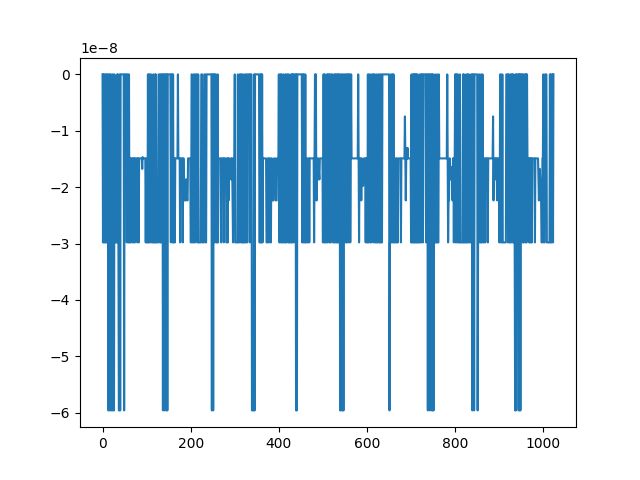

In [14]:
res_hls = fir_hw(x)
res_py = fir_sw(x)

figure()
plot(res_hls)
plot(res_py)

In [11]:
hw_time = %timeit -n 100 -r 100 -o fir_hw(x)
sw_time = %timeit -n 1 -r 10 -o fir_sw(x)
lib_time = %timeit -n 100 -r 100 -o fir_lib(x)

print('Performance gain hw/lib:', lib_time.average / hw_time.average)
print('Performance gain hw/sw:', sw_time.average / hw_time.average)

105 µs ± 2.2 µs per loop (mean ± std. dev. of 100 runs, 100 loops each)
338 ms ± 1.9 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
721 µs ± 10.7 µs per loop (mean ± std. dev. of 100 runs, 100 loops each)
Performance gain hw/lib: 6.83646087129251
Performance gain hw/sw: 3204.748944975168
